<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/Ev_Fiyat_Tahmini_(Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proje Açıklaması
Bu proje, California konut piyasasındaki ev fiyatlarını (median_house_value) tahmin etmek için bir makine öğrenimi modeli geliştirmeyi amaçlamaktadır. Veri seti, coğrafi konum, ev özellikleri (oda sayısı, nüfus vb.) ve okyanus yakınlığı gibi demografik bilgileri içerir. Proje, veri bilimi yaşam döngüsünün tüm aşamalarını kapsar: veri keşfi, temizlik, özellik mühendisliği, model seçimi, hiperparametre optimizasyonu ve sonuçların görselleştirilmesi. Aşağıda projenin ana bileşenleri ve zorluk seviyesi detaylandırılmıştır:

<ipython-input-3-90fcf4f2d438>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)


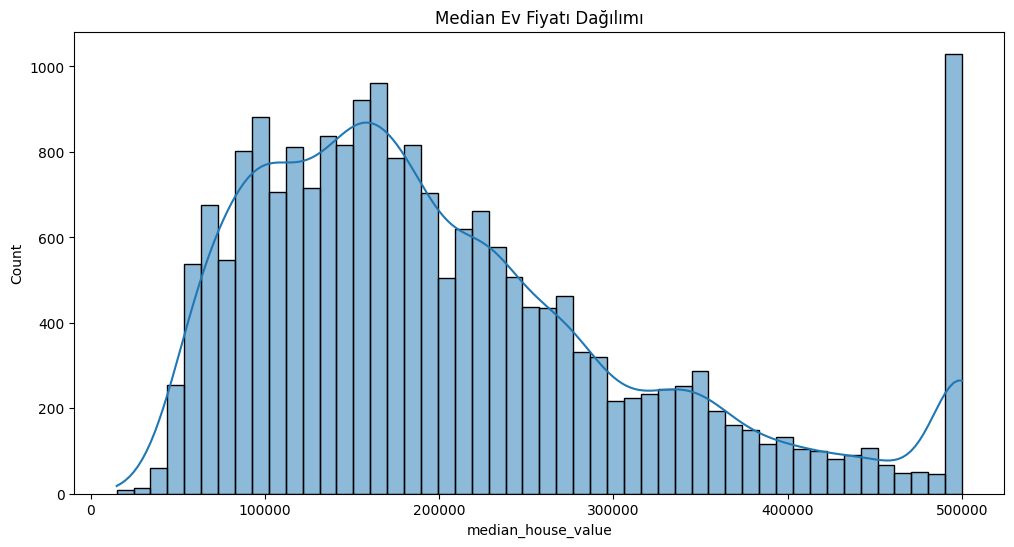

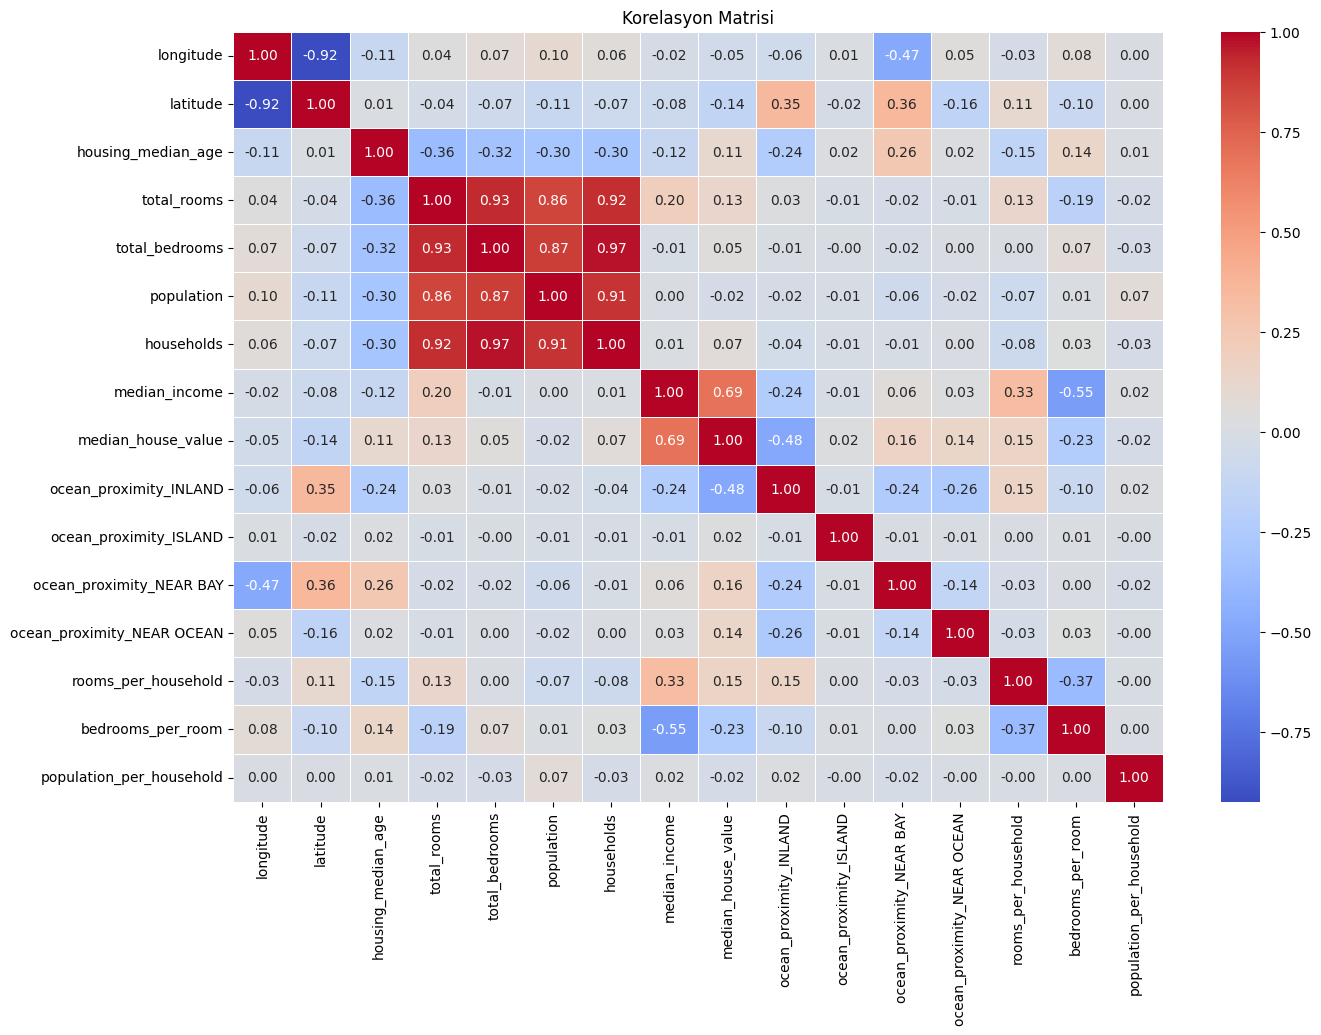

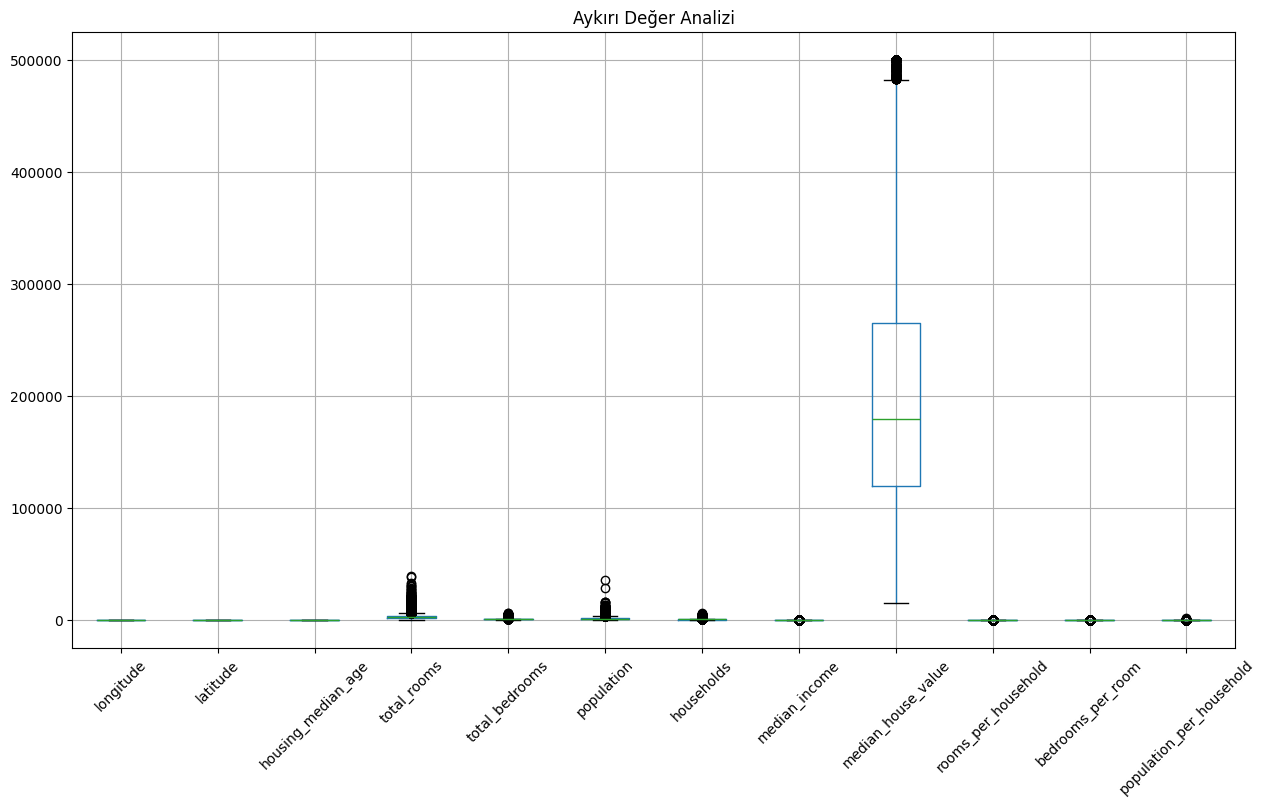


Lineer Regresyon Performansı:


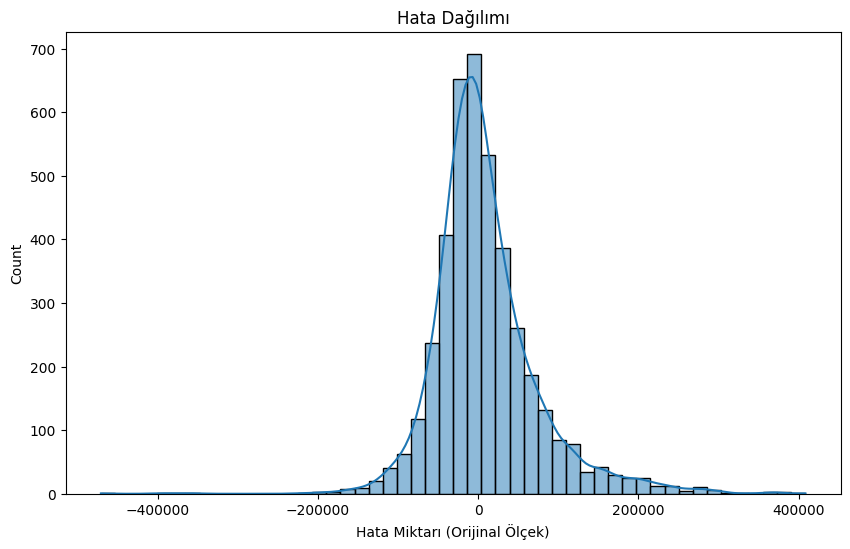


Random Forest Performansı:


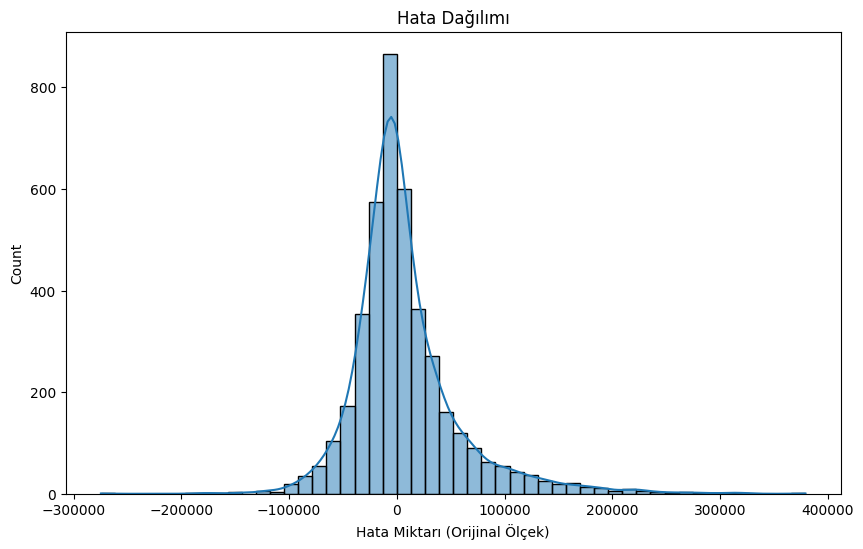

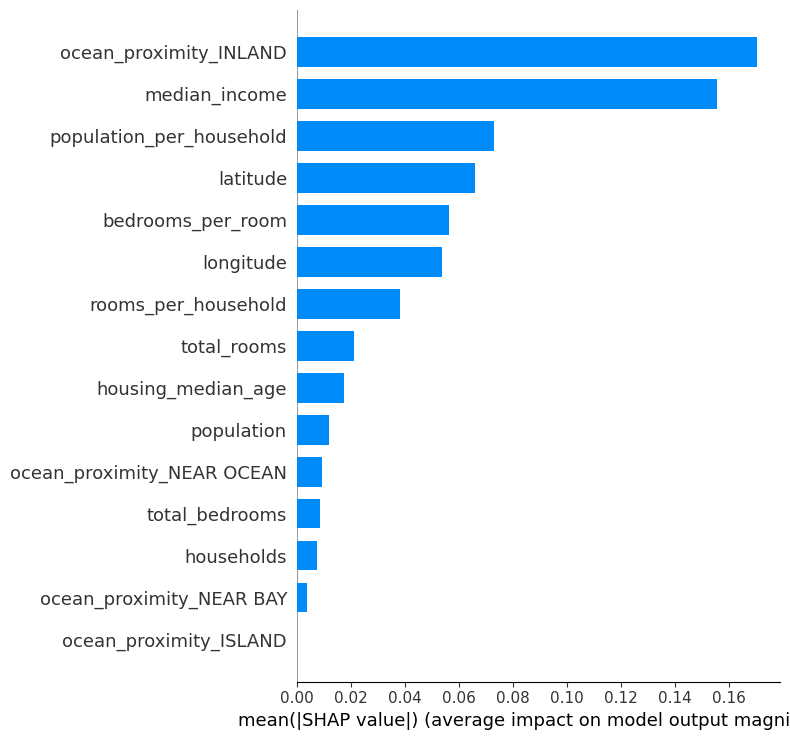

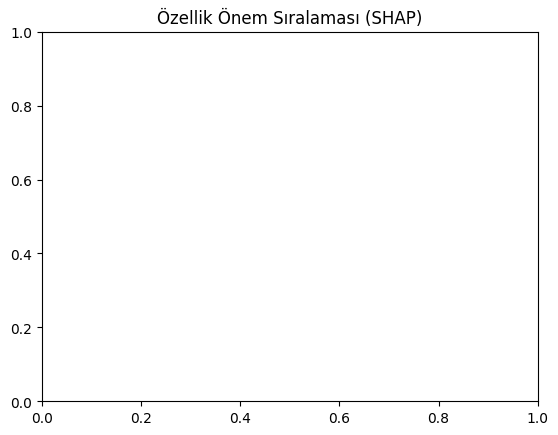


Çapraz Doğrulama Sonuçları:
LinearRegression:
Ortalama R²: 0.7202 | Standart Sapma: 0.0032

RandomForestRegressor:
Ortalama R²: 0.8269 | Standart Sapma: 0.0037



In [3]:
# GEREKLİ KÜTÜPHANELER
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap

# VERİ YÜKLEME
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
df = pd.read_csv(url)

# 1. VERİ ÖN İŞLEME (Korelasyon Matrisi Öncesi Gerekli Düzenlemeler)
# -----------------------------------------------------------------
# Eksik verileri medyan ile doldurma
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)

# Kategorik değişkeni one-hot encoding ile dönüştürme (Korelasyon Matrisi için önce yapılmalı!)
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first=True)

# Yeni özellikler türetme
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']

# 2. VERİ GÖRSELLEŞTİRME
# -----------------------------------------------------------------
# Hedef değişken dağılımı
plt.figure(figsize=(12,6))
sns.histplot(df['median_house_value'], kde=True, bins=50)
plt.title("Median Ev Fiyatı Dağılımı")
plt.show()

# Korelasyon matrisi (Artık kategorik sütun yok)
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Korelasyon Matrisi")
plt.show()

# 3. AYKIRI DEĞER ANALİZİ
# -----------------------------------------------------------------
# Sayısal sütunlar için boxplot
numeric_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15,8))
df[numeric_cols].boxplot(rot=45)
plt.title("Aykırı Değer Analizi")
plt.show()

# Winsorization ile aykırı değer baskılama
def winsorize_column(series, lower=0.05, upper=0.95):
    lower_limit = series.quantile(lower)
    upper_limit = series.quantile(upper)
    return series.clip(lower_limit, upper_limit)

df[numeric_cols] = df[numeric_cols].apply(winsorize_column)

# 4. HEDEF DEĞİŞKEN DÖNÜŞÜMÜ
# -----------------------------------------------------------------
y = np.log1p(df['median_house_value'])  # Log dönüşümü
X = df.drop('median_house_value', axis=1)

# 5. VERİ BÖLME VE ÖLÇEKLENDİRME
# -----------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. MODEL EĞİTİMİ VE OPTİMİZASYON
# -----------------------------------------------------------------
# Lineer Regresyon Optimizasyonu
lr_grid = GridSearchCV(
    LinearRegression(),
    param_grid={'fit_intercept': [True, False], 'positive': [True, False]},
    cv=5,
    scoring='neg_mean_squared_error'
)
lr_grid.fit(X_train_scaled, y_train)
best_lr = lr_grid.best_estimator_

# Random Forest Optimizasyonu
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'max_features': ['sqrt', 'log2']
    },
    cv=5,
    scoring='neg_mean_squared_error'
)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_

# 7. MODEL DEĞERLENDİRME
# -----------------------------------------------------------------
def enhanced_evaluation(model, X_test, y_test, log_transform=True):
    y_pred = model.predict(X_test)

    # Log dönüşümünün tersini al
    if log_transform:
        y_test = np.expm1(y_test)
        y_pred = np.expm1(y_pred)

    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }

    # Hata dağılımı görselleştirme
    plt.figure(figsize=(10,6))
    sns.histplot((y_test - y_pred), bins=50, kde=True)
    plt.title("Hata Dağılımı")
    plt.xlabel("Hata Miktarı (Orijinal Ölçek)")
    plt.show()

    return metrics

# Performans karşılaştırması
print("\nLineer Regresyon Performansı:")
lr_metrics = enhanced_evaluation(best_lr, X_test_scaled, y_test)

print("\nRandom Forest Performansı:")
rf_metrics = enhanced_evaluation(best_rf, X_test_scaled, y_test)

# 8. MODEL YORUMLULUĞU
# -----------------------------------------------------------------
# SHAP Değerleri
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_scaled)

plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns, plot_type="bar")
plt.title("Özellik Önem Sıralaması (SHAP)")
plt.show()

# 9. ÇAPRAZ DOĞRULAMA
# -----------------------------------------------------------------
print("\nÇapraz Doğrulama Sonuçları:")
for model in [best_lr, best_rf]:
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    print(f"{model.__class__.__name__}:")
    print(f"Ortalama R²: {scores.mean():.4f} | Standart Sapma: {scores.std():.4f}\n")